In [196]:
import pandas as pd
import json
import datetime
from dateutil.parser import parse
import re
import time
from matplotlib import pyplot as plt
import wordcloud,jieba
from PIL import Image
import collections
import numpy as np
from datetime import timezone,timedelta

In [23]:
comp = re.compile('</?\w+[^>]*>')
def strip_html(s:str):
    return comp.sub('',s)

In [3]:
df = pd.read_csv('analysis_src_1.csv')

In [4]:
print(df.shape)

(204574, 2)


# 数据预处理

In [8]:
big_result = []
for i in range(0,df.shape[0]):
    big_result.append(json.loads(json.dumps(eval(df.iloc[i][1]))))

In [116]:
for r in big_result:
    r['user_gender'] = r['user']['gender']
    r['user_name'] = r['user']['screen_name']
    r['user_avt'] = r['user']['profile_image_url']
    r['user_id'] = r['user']['profile_url'].split('=')[-1]

In [120]:
df_out_big = pd.DataFrame(big_result,columns=["created_at","text","user_name","user_gender","user_avt","user_id"])

In [121]:
df_out_big

,created_at,text,user_name,user_gender,user_avt,user_id
0,Mon Jun 15 17:38:33 +0800 2020,李文亮医生，你好！今天来晚了，对不起！,没得昵称200110,m,https://tvax3.sinaimg.cn/crop.0.0.996.996.180/...,7417115858
1,Mon Jun 15 17:38:07 +0800 2020,李医生，你好，三文鱼有错吗？,灰蝶出茧,f,https://tvax3.sinaimg.cn/crop.0.0.996.996.180/...,1406956225
2,Mon Jun 15 17:32:22 +0800 2020,"李医生，心情不好<span class=""url-icon""><img alt=[失望] s...",小胖是有梦想地star,f,https://tvax1.sinaimg.cn/crop.23.0.1195.1195.1...,5776562305
3,Mon Jun 15 17:24:45 +0800 2020,回复<a href='/n/社员都是向阳花2003'>@社员都是向阳花2003</a>：不知...,宗深,f,https://tva2.sinaimg.cn/crop.0.0.664.664.180/a...,2797812007
4,Mon Jun 15 17:23:03 +0800 2020,[蜡烛],no-name1999,f,https://tvax2.sinaimg.cn/crop.0.13.750.750.180...,2244640803
...,...,...,...,...,...,...
204569,Sat Apr 04 04:57:41 +0800 2020,[蜡烛][蜡烛][蜡烛][蜡烛],马马马马马珂珂,f,https://tvax4.sinaimg.cn/crop.0.0.512.512.180/...,5342016756
204570,Sat Apr 04 04:57:19 +0800 2020,谢谢您 您永远活在我们心里[蜡烛][蜡烛][蜡烛],xxmiing_,f,https://tvax3.sinaimg.cn/crop.0.0.996.996.180/...,5921328531
204571,Sat Apr 04 04:57:13 +0800 2020,"李医生，很难过以这样的方式跟您说话<span class=""url-icon""><img a...",周杰伦的小迷妹er,f,https://tvax1.sinaimg.cn/crop.0.0.512.512.180/...,3559359872
204572,Sat Apr 04 04:57:10 +0800 2020,本来已经想好了写什么，可打开你的微博，发现自己啥都不想写了 兄弟，我想你了[蜡烛][蜡烛]...,贵族阳光灬96959,m,https://tvax2.sinaimg.cn/crop.0.0.996.996.180/...,6653762573


In [200]:
df_out_big.to_csv('./load_result_200k_with_id.csv',index=False,encoding="utf_8_sig")

# 数据分析
--- 

## 概览
----

### 男女比

In [18]:
m=0
f=0
for i in range(0,df_out_big.shape[0]):
    c = df_out_big.iloc[i][3]
    if c=='f':
        f = f+1
    elif c=='m':
        m = m+1

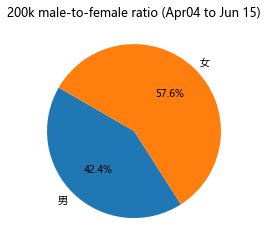

In [73]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #用来正常显示中文标签
labels = ['男','女']
sizes = (m,f)
explode = (0,0)
plt.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',shadow=False,startangle=150)
plt.title('200k male-to-female ratio (Apr04 to Jun 15)')
plt.show()

----
### 词频与词云

In [26]:
text_col = df_out_big['text']
text_col.shape
cut_text_col = []
for text in text_col:
    cut_text_col.append(jieba.lcut(strip_html(text)))
print(cut_text_col[2])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\NathanY\AppData\Local\Temp\jieba.cache
Loading model cost 0.599 seconds.
Prefix dict has been built successfully.


['李医生', '，', '心情', '不好']


In [50]:
cut_col_list = [i for j in cut_text_col for i in j]
punctuation_marks = ['，',',','!','！','。','.','、','~','[',']','【','】',' ']
stop_words = open('stopwords.words','r',encoding='utf-8').read().split('\n')
cut_col_list_stripped = list(filter(lambda x:x not in punctuation_marks,cut_col_list))
cut_col_list_stripped_stopped = list(filter(lambda x:x not in stop_words,cut_col_list_stripped))
all_txt = " ".join(cut_col_list_stripped_stopped)

len(all_txt)

3882673

#### 词频

In [110]:
words_count = collections.Counter(cut_col_list_stripped_stopped)
words_count_top = words_count.most_common(20)
print(words_count_top)
print(len(cut_col_list_stripped_stopped))

[('蜡烛', 92409), ('李医生', 59784), ('好', 30747), ('都', 18045), ('晚安', 16311), ('恭喜', 15246), ('不', 12745), ('人', 11951), ('？', 11725), ('白', 11321), ('希望', 10832), ('很', 10588), ('…', 10013), ('🙏', 9757), ('想', 9132), ('会', 8580), ('说', 7423), ('走', 7130), ('🕯', 7054), ('一个', 6980)]
1351961


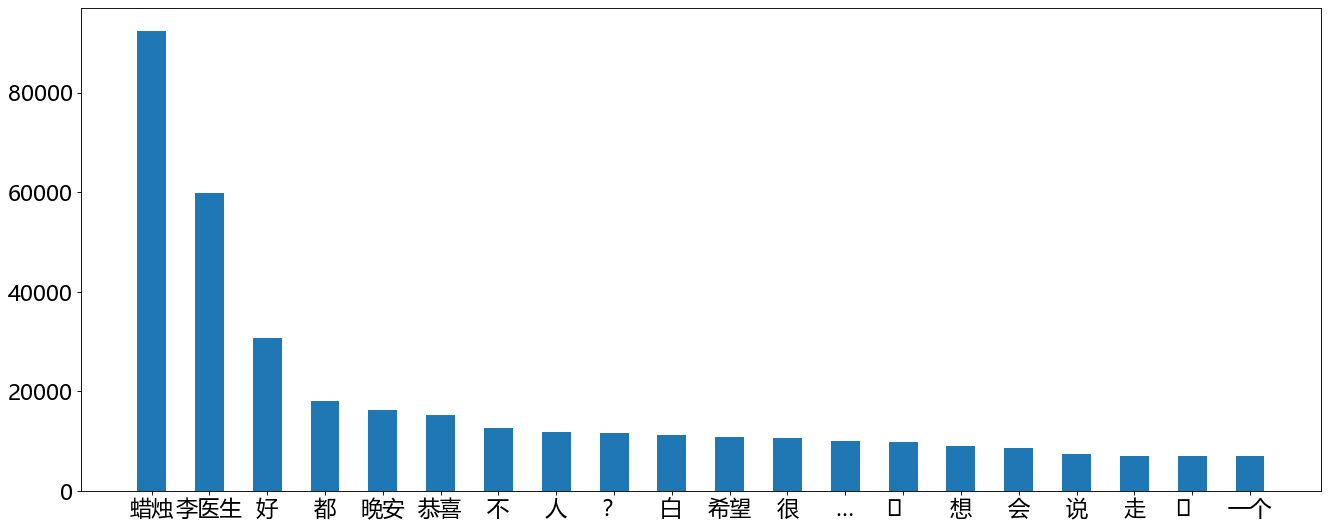

In [85]:
plt.figure(figsize=(20,8),dpi=80)
words = []
count = []
for (w,c) in words_count_top:
    words.append(w)
    count.append(c)
x = range(len(words))
plt.bar(x,count,width=0.5)
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.xticks(x,words)
plt.tick_params(labelsize=20)
plt.savefig('./words-freq-'+str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))+'.png',dpi=80,bbox_inches='tight')
plt.show()

#### 词云

In [58]:

w = wordcloud.WordCloud(\
    width = 1000, height = 700,\
    background_color = "white",     font_path = "msyh.ttc",scale=16,collocations=False
)


w.generate_from_text(all_txt)

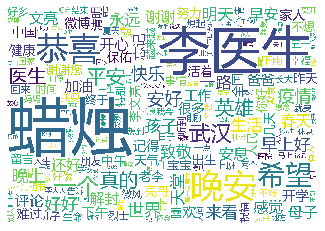

<Figure size 432x288 with 0 Axes>

In [59]:
plt.imshow(w)
plt.axis("off")
plt.figure()
plt.show()

In [60]:
w.to_file('./cloud-'+str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))+'.png')

----
## 详细内容

----
### 时间序列分析

#### 评论量——日期

In [123]:
print(df_out_big.shape)
df_out_big_norepeat = df_out_big.drop_duplicates(keep='first')
print(df_out_big_norepeat.shape)
dates = {}
for i in range(0,df_out_big.shape[0]):
    d = parse(df_out_big.iloc[i][0]).date().strftime('%m-%d')
    if dates.get(d)==None:
        dates[d]=1
    else:
        dates[d]+=1

(204574, 6)
(204574, 6)


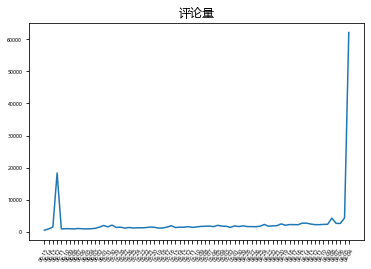

In [122]:
x_data = []
y_data = []
for k in dates:
    x_data.append(k)
    y_data.append(dates[k])

plt.plot(x_data,y_data)
plt.title('评论量')
plt.xticks(rotation=60)
plt.tick_params(labelsize=5)
plt.show()

#### 评论量——小时

In [184]:
print(df_out_big.shape)
df_out_big_norepeat = df_out_big.drop_duplicates(keep='first')
print(df_out_big_norepeat.shape)
dates = {}
for i in range(0,df_out_big.shape[0]):
    d = parse(df_out_big.iloc[i][0])
    d = d +timedelta(hours=8)
    d_str = d.astimezone(timezone.utc).strftime('%m-%d-%H')
    if dates.get(d_str)==None:
        dates[d_str]=1
    else:
        dates[d_str]+=1

(204574, 6)
(204574, 6)


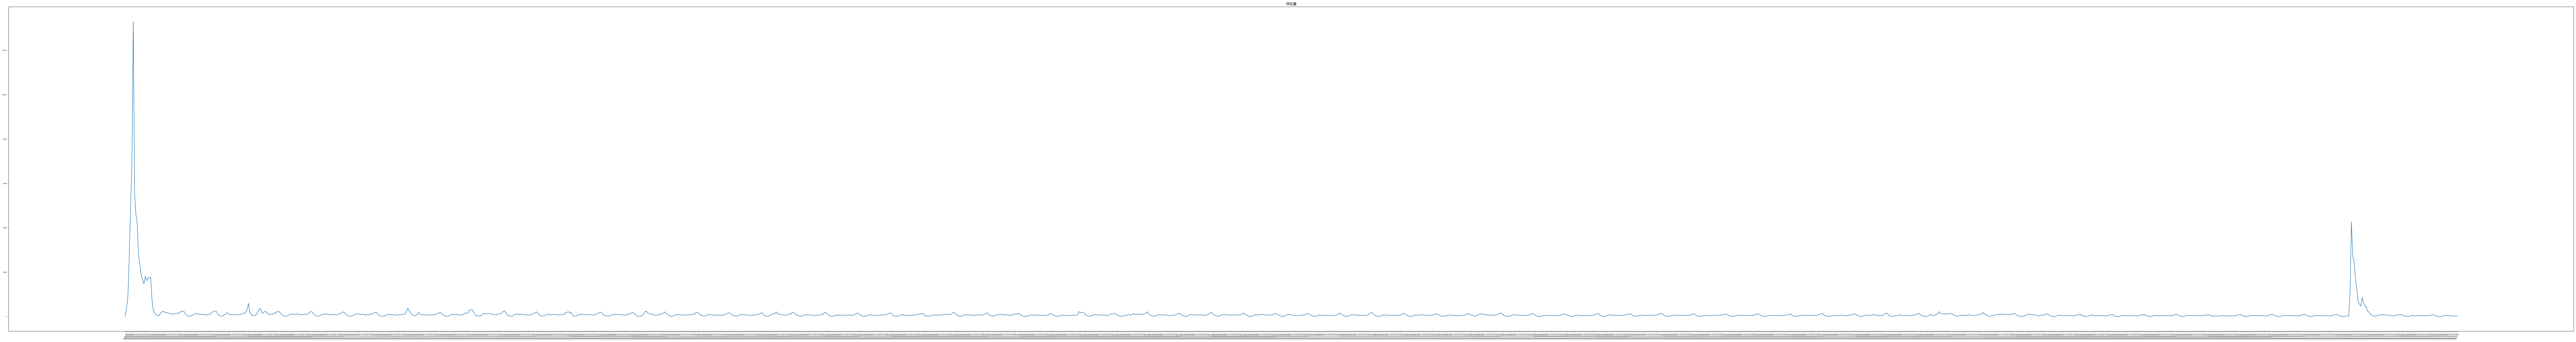

In [185]:
x_data = []
y_data = []
for k in dates:
    x_data.append(k)
    y_data.append(dates[k])
x_data.reverse()
y_data.reverse()
plt.figure(figsize=(120,16),dpi=160)
plt.plot(x_data,y_data)
plt.title('评论量')
plt.xticks(rotation=60)
plt.tick_params(labelsize=5)
plt.tight_layout()
plt.savefig('./com-freq-daily-'+str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))+'.png',dpi=160,bbox_inches='tight')
plt.show()

#### 评论男女比日期变化

In [167]:
dates = {}
m_total = 1
f_total = 1
for i in range(0,df_out_big.shape[0]):
    d = parse(df_out_big.iloc[i][0]).date().strftime('%m-%d')
    if df_out_big.iloc[i][3]=='f':
        f_total +=1
    else:
        m_total+=1
    dates[d]=m_total/f_total

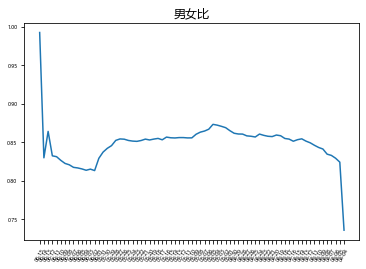

In [170]:
x_data = []
y_data = []
for k in dates:
    x_data.append(k)
    y_data.append(dates[k])

plt.plot(x_data,y_data)
plt.title('男女比')
plt.xticks(rotation=60)
plt.tick_params(labelsize=5)
plt.savefig('./mf-ratio-daily-'+str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))+'.png',dpi=160,bbox_inches='tight')
plt.show()

6月15日的数据截止到下午2点，此时男女比接近1，但4月以来男女比均在0.75左右浮动，继续分析：
----

#### 评论男女比小时变化

In [186]:
hours = {}
for i in range(0,df_out_big.shape[0]):
    d = parse(df_out_big.iloc[i][0])
    d = d +timedelta(hours=8)
    h_str = d.astimezone(timezone.utc).strftime('%H')
    if hours.get(h_str)==None:
        hours[h_str]={'m':1,'f':1,'m_total':1,'f_total':1}
    else:
        hours[h_str][df_out_big.iloc[i][3]]+=1
        hours[h_str][df_out_big.iloc[i][3]+'_total']+=1

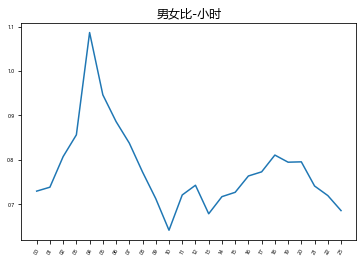

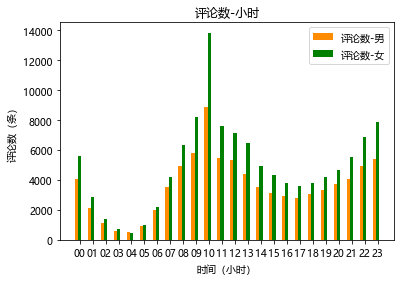

In [199]:
x_data = []
y_data = []
m_data = []
f_data = []
for k in hours:
    x_data.append(k)
    y_data.append(hours[k]['m']/hours[k]['f'])
    m_data.append(hours[k]['m_total'])
    f_data.append(hours[k]['f_total'])
x_data.reverse()
y_data.reverse()
f_data.reverse()
m_data.reverse()
index_0 = x_data.index('00')
x_data = x_data[index_0:]+x_data[0:index_0]
y_data = y_data[index_0:]+y_data[0:index_0]
f_data = f_data[index_0:]+f_data[0:index_0]
m_data = m_data[index_0:]+m_data[0:index_0]


plt.plot(x_data,y_data)
plt.title('男女比-小时')
plt.xticks(rotation=60)
plt.tick_params(labelsize=5)
plt.savefig('./mf-ratio-hour-'+str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))+'.png',dpi=160,bbox_inches='tight')
plt.show()

width=0.25
index = np.arange(len(x_data))
plt.bar(index,m_data,width=width,label='评论数-男',color='darkorange')
plt.bar(index+width,f_data,width=width,label='评论数-女',color='green',tick_label=x_data)
plt.xticks()
plt.xlabel('时间（小时）')
plt.ylabel('评论数（条）')
plt.title('评论数-小时')
plt.legend()
plt.savefig('./mf-count-hour-'+str(datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))+'.png',dpi=160,bbox_inches='tight')
plt.show()

### 多次评论

In [207]:
id_list = list(df_out_big['user_id'])
cnt = collections.Counter()
for id in id_list:
    cnt[id]+=1
#id_count = collections.Counter(id_list)
b50,b25,b5 = 0,0,0
for id in cnt:
    if cnt[id]>50:
        b50+=1
    elif cnt[id]>25:
        b25+=1
    elif cnt[id]>5:
        b5+=1
print(b50,b25,b5)

print(len(id_list),"->",len(cnt))

204574 -> 105502


### 情感分析测试

In [117]:
from snownlp import SnowNLP

t = df_out_big.iloc[0][1]
result = SnowNLP(t)
print(result.words,result.sentiments)

for i in range(0,10):
    print(df_out_big.iloc[i][1],SnowNLP(df_out_big.iloc[i][1]).sentiments)

李文亮医生，你好！今天来晚了，对不起！ 0.14954548456250127
李医生，你好，三文鱼有错吗？ 0.2466775143881692
李医生，心情不好<span class="url-icon"><img alt=[失望] src="//h5.sinaimg.cn/m/emoticon/icon/default/d_shiwang-7925938d93.png" style="width:1em; height:1em;" /></span> 0.0660590495163329
回复<a href='/n/社员都是向阳花2003'>@社员都是向阳花2003</a>：不知道您经历了什么，试着找亲近的人给与支持、理解和帮助。如果还不够，可以寻求心理帮助，帮助自己走过艰难时刻。 0.9850353371463167
[蜡烛] 0.2500000000000001
李医生，三亚今天终于下雨了！ 0.2758072431241191
李医生，我瘦了，从72公斤，瘦到了63公斤，你在天堂还好吗？ 0.9944334484499836
李医生，疫情好像又开始了，希望一起都快点过去，不要让你们的牺牲白费<span class="url-icon"><img alt=[太阳] src="//h5.sinaimg.cn/m/emoticon/icon/others/w_taiyang-90b439dadf.png" style="width:1em; height:1em;" /></span> 0.1968319803819356
生活太南了 0.8819939787265193
回复<a href='/n/c1021'>@c1021</a> 的表态:<span class="url-icon"><img alt=[作揖] src="//h5.sinaimg.cn/m/emoticon/icon/others/h_zuoyi-cb12e18fd5.png" style="width:1em; height:1em;" /></span> 0.035385421433562936


In [209]:
test_txt = """{"ok":1,"data":{"cards":[{"card_type":11,"card_group":[{"card_type":42,"display_arrow":0,"desc":"\u8d26\u53f7\u4fe1\u606f"},{"card_type":41,"item_name":"\u6635\u79f0","item_content":"\u8346\u68d8\u4e4b\u5fc3o"},{"card_type":41,"item_name":"\u7b80\u4ecb","item_content":"\u7ea2\u5c18\u7d2b\u964c\u72ec\u884c\u5ba2\uff0c\u613f\u4e3a\u4e00\u652f\u4e01\u9999\u82b1"},{"card_type":41,"item_name":"\u6ce8\u518c\u65f6\u95f4","item_content":"2012-04-09"},{"item_name":"\u9633\u5149\u4fe1\u7528","display_arrow":1,"card_type":41,"item_content":"\u4fe1\u7528\u8f83\u597d","actionlog":{"act_code":"594","ext":"uid:6526442008|ouid:2704763507|verified_type:-1|ptype:0|load_read_level:","oid":"https:\/\/service.account.weibo.com\/sunshine\/guize?sinainternalbrowser=topnav","fid":"2302832704763507_-_INFO","cardid":"230283_-_WEIBO_INDEX_USERINFO_CREDIT","uicode":"10000198"},"scheme":"https:\/\/service.account.weibo.com\/sunshine\/guize?sinainternalbrowser=topnav&luicode=10000011&lfid=2302832704763507_-_INFO"}]},{"card_type":11,"card_group":[{"card_type":42,"display_arrow":0,"desc":"\u4e2a\u4eba\u4fe1\u606f"},{"card_type":41,"item_name":"\u6027\u522b","item_content":"\u5973"},{"card_type":41,"item_name":"\u751f\u65e5","item_content":"0000-06-26  \u5de8\u87f9\u5ea7"},{"card_type":41,"item_name":"\u6240\u5728\u5730","item_content":"\u5c71\u4e1c \u9752\u5c9b"}]},{"card_type":11,"is_asyn":1,"card_group":[],"itemid":"2306182704763507_-_3861","async_api":"\/api\/container\/getItem?itemid=2306182704763507_-_3861&download="},{"card_type":11,"is_asyn":1,"card_group":[],"itemid":"2306182704763507_-_profileinterest","async_api":"\/api\/container\/getItem?itemid=2306182704763507_-_profileinterest&download="},{"card_type":11,"is_asyn":1,"card_group":[],"itemid":"2306182704763507_-_likes","async_api":"\/api\/container\/getItem?itemid=2306182704763507_-_likes&download="}],"cardlistInfo":{"show_style":1,"button":null,"can_shared":0,"cardlist_menus":[{"name":"\u5237\u65b0","type":"button_menus_refresh"},{"name":"\u8fd4\u56de\u9996\u9875","params":{"scheme":"sinaweibo:\/\/gotohome"},"type":"gohome"}],"v_p":"42","cardlist_title":"","desc":"","containerid":"2302832704763507_-_INFO","page":null},"banners":null,"scheme":"sinaweibo:\/\/cardlist?containerid=2302832704763507_-_INFO&_T_WM=84231961599&v_p=42&luicode=10000011&lfid=2302832704763507_-_INFO"}}"""

In [225]:
def parse_info(input_txt):
    data = json.loads(input_txt)
    cards = data['data']['cards']
    account_info = {}
    person_info = {}
    for c11 in cards:
        if str(c11).find('账号信息')!=-1:
            account_info = c11
        elif str(c11).find('个人信息')!=-1:
            person_info = c11
    reg_time,age,location = None,None,None
    for c41 in account_info['card_group']:
        if c41.get('item_name')=='注册时间':
            reg_time = c41['item_content']
    for c41 in person_info['card_group']:
        if c41.get('item_name')=='生日':
            age = c41['item_content']
        if c41.get('item_name')=='所在地':
            location=c41['item_content']
    return (reg_time,age,location)

In [226]:
print(parse_info(test_txt))

('2012-04-09', '0000-06-26  巨蟹座', '山东 青岛')


可见基于商品评论数据集训练的模型在此数据集上表现并不理想。

----
### 地域分布

In [124]:
df_out_big['user_id']

0         7417115858
1         1406956225
2         5776562305
3         2797812007
4         2244640803
             ...    
204569    5342016756
204570    5921328531
204571    3559359872
204572    6653762573
204573    1854880211
Name: user_id, Length: 204574, dtype: object

----
### 多次评论率